# Rilevamento e classificazioni di espressioni facciali
### Pricoco Andrea   1000044324
### Spina Simone     1000044375
Scopo del progetto è quello di addestrare un modello di learning nel riconoscere, data una foto, l'espressione facciale fatta dalla persona presente nell'immagine

# Caricamento del dataset
Come dataset abbiamo scelto di utilizzare FER-2013, reperito su kaggle.com. È un dataset composto da immagini 48x48 a scale di grigio

In [1]:
from glob import glob
from os.path import basename
classes = glob('FER-2013/train/*') #estraiamo le classi dalla cartella del dataset
classes = [basename(c) for c in classes]

num_classes = {c: i for i, c in enumerate(classes)}
print("Classes in dataset:",num_classes)

Classes in dataset: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Adesso prendiamo il path di ogni immagine e associamo a ogni immagine una classe a partire dal suo path

In [2]:
image_path = glob('FER-2013/train/*/*')

Rimuoviamo dal path il prefisso 'FER-2013' il quale potrebbe dare problemi in seguito

In [3]:
from pathlib import Path

image_path_cleaned = []

for p in image_path:
    if not p:
        image_path_cleaned.append('')
        continue

    # Normalizza i separatori
    p = Path(p.replace("\\", "/"))

    try:
        relative_path = p.relative_to('FER-2013')
        image_path_cleaned.append(str(relative_path))
    except ValueError:
        # 'FER-2013' non è presente
        image_path_cleaned.append(str(p))

In [4]:
def class_from_path(path):
    _, cl, _ = path.split('\\')
    return num_classes[cl]

labels = [class_from_path(im) for im in image_path] #abbiamo associato a ogni immagine la sua classe

Realizziamo il dataframe con pandas che conterrà le immagini e le rispettive e prepariamolo per il training, test e validation

In [5]:
import pandas as pd
dataset = pd.DataFrame({'path': image_path_cleaned, 'label': labels})
print(dataset)

from sklearn.model_selection import train_test_split #train_test_split fa anche uno shuffle degli elementi nel dataset
def split_train_val_test(dataset, perc = [0.6, 0.1, 0.3]):
    #stiamo definendo le proporzioni secondo le quali suddividere i dati, 60% training, 10% validation e 30% testing
    train, testval = train_test_split(dataset, test_size = perc[1] + perc[2])
    #la funzione suddivide i dati solo a due alla volta quindi utilizziamola 3 volte per fare la suddivisione
    val, test = train_test_split(testval, test_size = perc[2])
    return train, test, val

                                      path  label
0        train\angry\Training_80704628.jpg      0
1        train\angry\Training_80720718.jpg      0
2        train\angry\Training_80724752.jpg      0
3        train\angry\Training_80785973.jpg      0
4        train\angry\Training_80804172.jpg      0
...                                    ...    ...
7874  train\surprise\Training_99916297.jpg      6
7875  train\surprise\Training_99924420.jpg      6
7876  train\surprise\Training_99937001.jpg      6
7877  train\surprise\Training_99951755.jpg      6
7878  train\surprise\Training_99984132.jpg      6

[7879 rows x 2 columns]


In [6]:
train, val, test = split_train_val_test(dataset)
print("Numero di elementi nei dataset:")
print(len(train))
print(len(val))
print(len(test))

Numero di elementi nei dataset:
4727
946
2206


Inseriamo i dataframe in dei file csv ed esportiamoli come dataset

In [7]:
train.to_csv("FER-2013/train.csv")
val.to_csv("FER-2013/val.csv")
test.to_csv("FER-2013/test.csv")

#Creazione del file csv che conterrà l'associazione degli id numerici delle classi ai nomi delle classi
classes, ids = zip(*num_classes.items())
classes = pd.DataFrame({'id':ids, 'class':classes}).set_index('id')
classes.to_csv('FER-2013/classes.csv')

Prendiamo le informazioni dai file csv che abbiamo creato e restituiamole a pytorch per prepararle al training

In [8]:
import torch
from torch.utils import data
from os.path import join
from PIL import Image

class CSVImageDataSet(data.Dataset):
    def __init__(self, data_root, csv, transform = None):
        self.data_root = data_root
        self.data = pd.read_csv(csv)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        im_path, im_label = self.data.iloc[index]['path'], self.data.iloc[index].label
        im = Image.open(join(self.data_root, im_path)).convert('RGB')
        
        if self.transform is not None:
            im = self.transform(im)
            
        return im, im_label
    
classes = pd.read_csv('FER-2013/classes.csv').to_dict()['class'] 

Creiamo i dataset che ci interessano:

In [9]:
dataset_train = CSVImageDataSet('FER-2013/', 'FER-2013/train.csv')
dataset_valid = CSVImageDataSet('FER-2013/', 'FER-2013/val.csv')
dataset_test = CSVImageDataSet('FER-2013/', 'FER-2013/test.csv')

# Preparazione del modello
Il modello scelto è efficientNet-B1, buono considerando le immagini del dataset 48 x 48

In [10]:
from torchvision.models import efficientnet_b1 #con questa versione del modello i pesi sarebbero inizializzati casualmente
from torchvision.models import EfficientNet_B1_Weights #qui sono inizializzati a doc per imagenet
from torch import nn

model = efficientnet_b1(weights = EfficientNet_B1_Weights.DEFAULT) #con DEFAULT otteniamo la versione più aggiornata dei pesi preaddestrati per efficientNetB0
num_class = 7
in_feature = model.classifier[1].in_features #ritorna il numero di neuroni in input al layer finale della rete
model.classifier[1] = nn.Linear(in_feature, num_class)

# Preprocessing dei dati
Facciamo data augmentation sui dati

In [11]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224), #è un ritaglio dell'imagine
    transforms.RandomHorizontalFlip(), #è un flip orizzontale con probabilità 0.5
    transforms.ToTensor(), #converte le immagini PIL in tensori di PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #sono valori standard di imageNet, infatti si usano questi quando si fa transfer learning
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #è un ritaglio dell'imagine
    transforms.RandomHorizontalFlip(), #è un flip orizzontale con probabilità 0.5
    transforms.ToTensor(), #converte le immagini PIL in tensori di PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

L'unica differenza tra il data augmentation per i dati training e test sta nel Crop, nel testing si fa CenterCrop per diminuire la variabilità, così facendo la valutazione risulta ripetibile e affidabile. Proviamo adesso a vedere a quanto possiamo portare il batch_size facendo benchmark su quest'ultimo

In [12]:
from torch.utils.data import DataLoader
import time
def test_batch_size(model, dataset, batch_sizes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    results = {}
    for bs in batch_sizes:
        loader = DataLoader(dataset, batch_size=bs)
        start = time.time()
        
        with torch.no_grad():
            for x, _ in loader:
                x = x.to(device)
                _ = model(x)
        end = time.time()
        print(f"Batch size {bs}: {end - start:.2f}s")
        results[bs] = end - start
    return results
    
FER2013_valid = CSVImageDataSet('FER-2013/', 'FER-2013/val.csv',
                                transform = test_transform)
result = test_batch_size(model, FER2013_valid, [16, 32, 64, 128])
batch_size = min(result, key=result.get)

print("best batch size:", batch_size)

Batch size 16: 36.53s
Batch size 32: 32.74s
Batch size 64: 32.05s
Batch size 128: 32.71s
best batch size: 64


Quindi prendiamo come dimensione del batch quella con i risultati migliori. Adesso sistemiamo i dataset anche per training e test

In [13]:
FER2013_train = CSVImageDataSet('FER-2013', 'FER-2013/train.csv',
                                transform = train_transform)
FER2013_test = CSVImageDataSet('FER-2013/', 'FER-2013/test.csv',
                                transform = test_transform)

FER2013_train_loader = DataLoader(FER2013_train, batch_size,
                                     num_workers = 0, shuffle = True)
FER2013_valid_loader = DataLoader(FER2013_valid, batch_size, num_workers=0)
FER2013_test_loader = DataLoader(FER2013_test, batch_size, num_workers=0)

# Training del modello


In [14]:
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import os
import time

class AvarageValueMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.sum = 0
        self.num = 0
        
    def add(self, value, num):
        self.sum += value*num
        self.num += num
        
    def value(self):
        try:
            return self.sum/self.num
        except:
            return None
        

def trainval_classifier(model, train_loader, valid_loader, exp_name = 'experiment', lr = 0.1, epochs = 10, momentum = 0.99, logdir = 'logs'):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum = momentum)
    loss_meter = AvarageValueMeter()
    acc_meter = AvarageValueMeter()
    
    writer = SummaryWriter(join(logdir, exp_name))
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    loader = {
        'train' : train_loader,
        'val' : valid_loader
    }
    
    global_step = 0
    os.makedirs("weights", exist_ok=True)
    
    for e in range(epochs):
        print(f"Epoch {e + 1} of {epochs}")
        start = time.time()
        
        #iteriamo tra due modalità: test e training
        for mode in ['train', 'val']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode == 'train'):  #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    x = batch[0].to(device)
                    y = batch[1].to(device)
                    output = model(x)
                    
                    #aggiorniamo il global step
                    #conterrà il numero di campioni visti durante il test
                    n = x.shape[0]#numero di elementi nel batch
                    global_step += n
                    l = criterion(output, y)
                    
                    if mode == 'train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        
                    acc = accuracy_score(y.to('cpu'), output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(), n)
                    acc_meter.add(acc, n)
                    
                    #loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode == 'train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
                        
            #una volta finita l'epoca, sia nel caso di training che test, loggiamo le stime finali
            writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
            writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)
                
        #conserviamo i pesi alla fine di un ciclo di training e test
        torch.save(model.state_dict(), f'weights/{exp_name}-{e+1}.pth')
        end = time.time()
        total_time = (end - start)/60
        print(f"{total_time:.2f}m")
    return model

Adesso lanciamo il training

In [27]:
EfficientNet_trained = trainval_classifier(model, FER2013_train_loader,
                                        FER2013_valid_loader, exp_name='efficientnet_FER2013_finetuning',
                                        lr = 0.001, epochs = 100)

Epoch 1 of 100
9.56m
Epoch 2 of 100
7.96m
Epoch 3 of 100
8.55m
Epoch 4 of 100
8.10m
Epoch 5 of 100
8.36m
Epoch 6 of 100
8.53m
Epoch 7 of 100
8.13m
Epoch 8 of 100
9.44m
Epoch 9 of 100
8.63m
Epoch 10 of 100
9.03m
Epoch 11 of 100
9.18m
Epoch 12 of 100
8.73m
Epoch 13 of 100
8.72m
Epoch 14 of 100
8.71m
Epoch 15 of 100
8.09m
Epoch 16 of 100
8.03m
Epoch 17 of 100
8.03m
Epoch 18 of 100
8.00m
Epoch 19 of 100
8.21m
Epoch 20 of 100
8.05m
Epoch 21 of 100
7.92m
Epoch 22 of 100
9.02m
Epoch 23 of 100
8.16m
Epoch 24 of 100
7.87m
Epoch 25 of 100
8.28m
Epoch 26 of 100
8.07m
Epoch 27 of 100
8.30m
Epoch 28 of 100
7.88m
Epoch 29 of 100
8.35m
Epoch 30 of 100
7.95m
Epoch 31 of 100
7.89m
Epoch 32 of 100
8.40m
Epoch 33 of 100
7.48m
Epoch 34 of 100
7.45m
Epoch 35 of 100
7.60m
Epoch 36 of 100
7.88m
Epoch 37 of 100
8.32m
Epoch 38 of 100
7.91m
Epoch 39 of 100
7.84m
Epoch 40 of 100
7.86m
Epoch 41 of 100
7.92m
Epoch 42 of 100
7.81m
Epoch 43 of 100
7.67m
Epoch 44 of 100
7.33m
Epoch 45 of 100
7.36m
Epoch 46 of 100
7.2

infine plottiamo i risultati in dei grafici, concludendo così la procedura di training

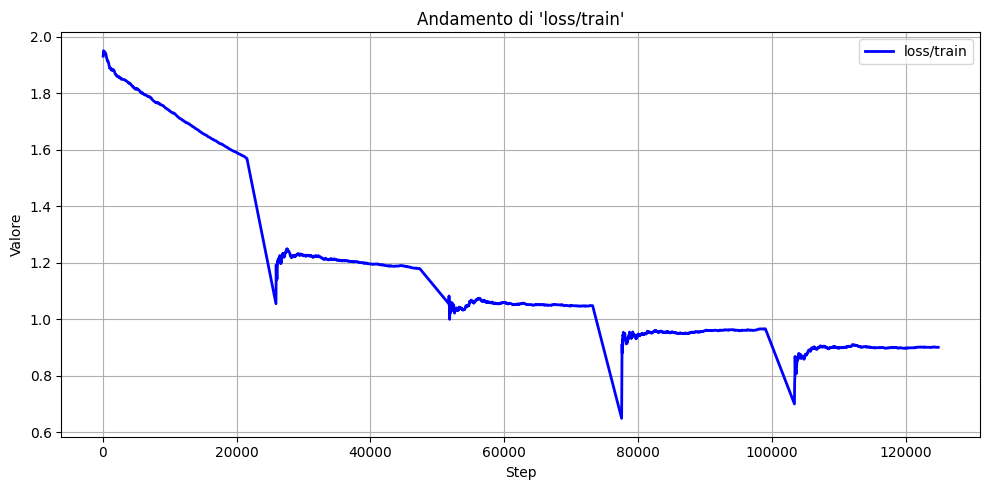

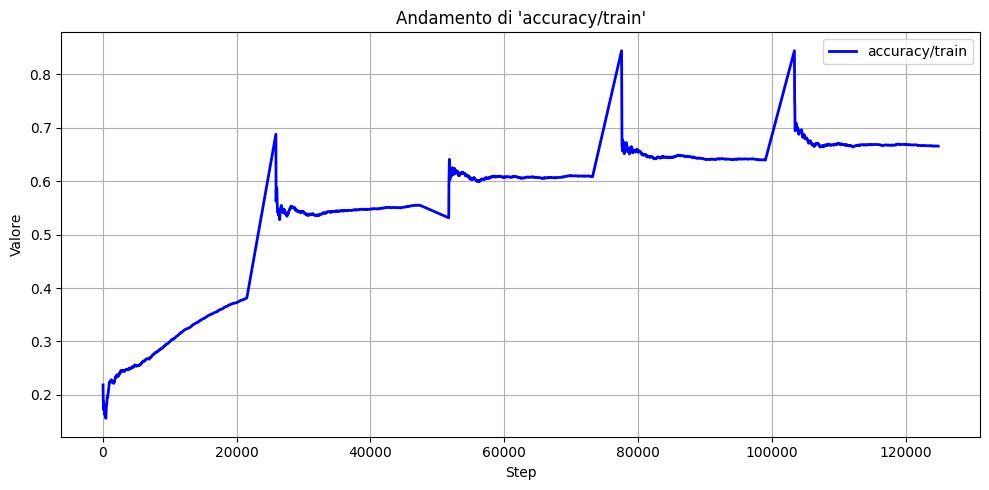

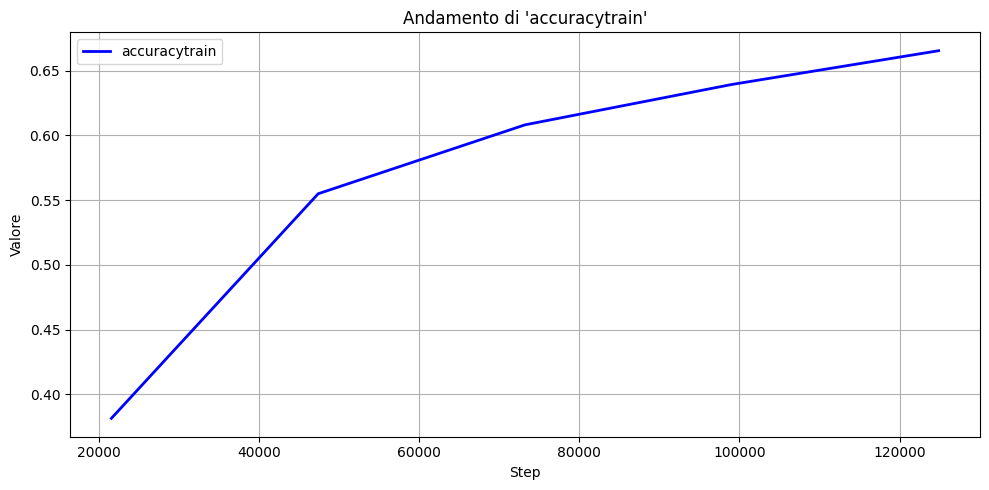

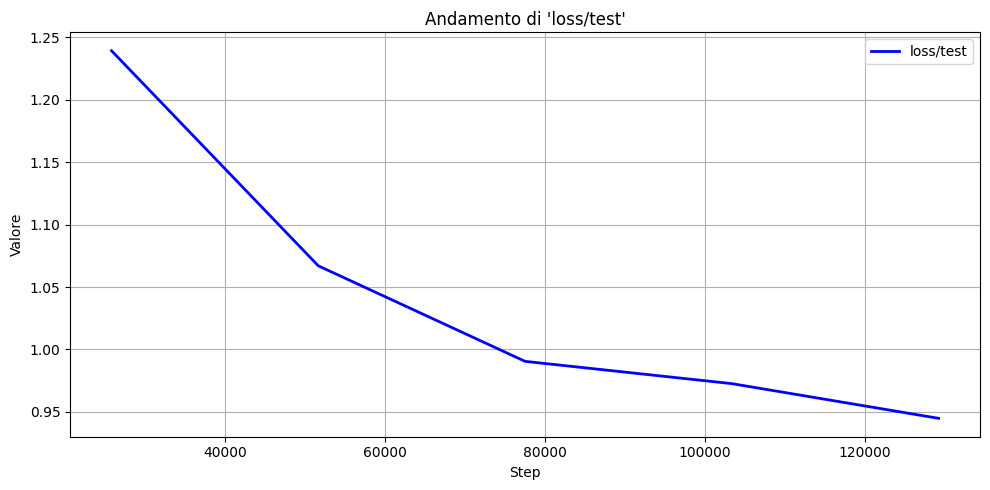

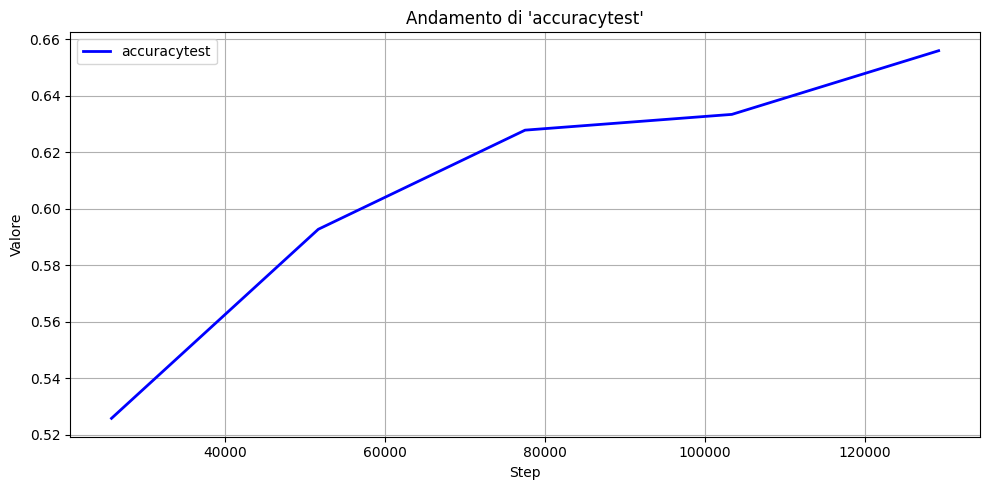

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

event_file = "logs/efficientnet_FER2013_finetuning/events.out.tfevents.1752247793.nokia4316.3068.0"

ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

for tag_to_plot in ea.Tags().get("scalars", []):

    if tag_to_plot not in ea.Tags()["scalars"]:
        print(f"Tag '{tag_to_plot}' non trovato. Disponibili: {ea.Tags()['scalars']}")
    else:
        events = ea.Scalars(tag_to_plot)
        steps = [e.step for e in events]
        values = [e.value for e in events]

        # === Plot ===
        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=tag_to_plot, color="blue", linewidth=2)
        plt.xlabel("Step")
        plt.ylabel("Valore")
        plt.title(f"Andamento di '{tag_to_plot}'")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Adesso scriviamo il codice per fare il test e farci dare l'accuracy del modello addestrato

In [15]:
import numpy as np
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            y = batch[1].to(device)
            
            output = model(x)
            preds = output.to('cpu').max(1)[1].numpy()
            labs = y.to('cpu').numpy()
            
            predictions.extend(list(preds))#predizioni
            labels.extend(list(labs))#etichette vere
        
    return np.array(predictions), np.array(labels)

In [16]:
EfficientNet_trained = efficientnet_b1(num_classes = 7)
EfficientNet_trained.load_state_dict(torch.load("weights/efficientnet_FER2013_finetuning-100.pth"))
EfficientNet_trained.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
EfficientNet_trained_test, FER2013_labels_test = test_classifier(EfficientNet_trained, FER2013_test_loader)
EfficientNet_test_accuracy = accuracy_score(FER2013_labels_test, EfficientNet_trained_test) * 100
print("Accuracy di EfficientNet su FER2013: %0.3f%%" % EfficientNet_test_accuracy)

Accuracy di EfficientNet su FER2013: 84.769%


# Matrice di confusione

In [18]:
def confusionMatrix(labels, preds):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    cm = confusion_matrix(labels, preds)
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - FER2013')
    plt.show()

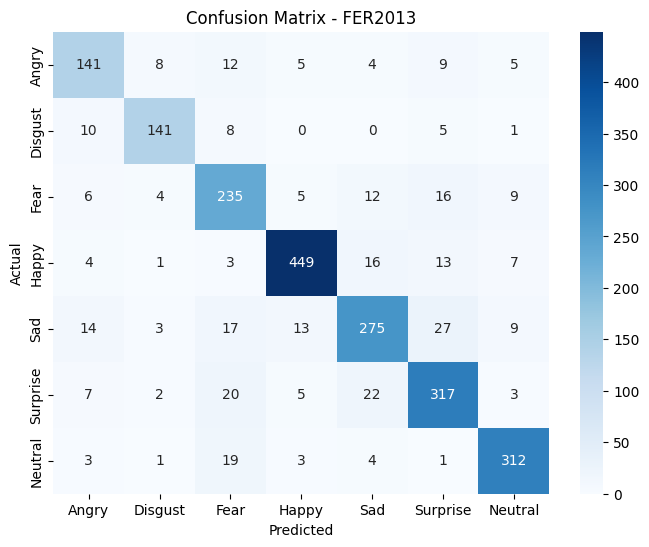

In [19]:
confusionMatrix(EfficientNet_trained_test, FER2013_labels_test)

# Confronto con altri modelli
Proviamo adesso ad addestrare altri modelli e confrontare i risultati tra i training effettuati

### Squeezenet

In [20]:
from torchvision.models import squeezenet1_0
from torchvision.models import SqueezeNet1_0_Weights
def get_squeezenet1_model(num_class = 7):
    model = squeezenet1_0(weights = SqueezeNet1_0_Weights.DEFAULT)
    num_class = 7
    model.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride = (1, 1))
    model.num_classes = num_class
    return model

In [ ]:
SqueezeNet_trained = trainval_classifier(get_squeezenet1_model(), FER2013_train_loader,
                                        FER2013_valid_loader, exp_name='squeezenet_FER2013_finetuning',
                                        lr = 0.001, epochs = 100)

Epoch 1 of 100
3.28m
Epoch 2 of 100
3.23m
Epoch 3 of 100
3.17m
Epoch 4 of 100
3.15m
Epoch 5 of 100
3.23m
Epoch 6 of 100
3.20m
Epoch 7 of 100
3.14m
Epoch 8 of 100
3.19m
Epoch 9 of 100
3.16m
Epoch 10 of 100
3.16m
Epoch 11 of 100
3.16m
Epoch 12 of 100
3.18m
Epoch 13 of 100
3.18m
Epoch 14 of 100
3.19m
Epoch 15 of 100
3.25m
Epoch 16 of 100
3.23m
Epoch 17 of 100
3.25m
Epoch 18 of 100
3.15m
Epoch 19 of 100
3.15m
Epoch 20 of 100
3.16m
Epoch 21 of 100
3.15m
Epoch 22 of 100
3.17m
Epoch 23 of 100
3.16m
Epoch 24 of 100
3.23m
Epoch 25 of 100
3.15m
Epoch 26 of 100
3.15m
Epoch 27 of 100
3.12m
Epoch 28 of 100
3.11m
Epoch 29 of 100
3.12m
Epoch 30 of 100
3.16m
Epoch 31 of 100
3.15m
Epoch 32 of 100
3.15m
Epoch 33 of 100
3.14m
Epoch 34 of 100
3.15m
Epoch 35 of 100
3.12m
Epoch 36 of 100
3.18m
Epoch 37 of 100
3.10m
Epoch 38 of 100
3.09m
Epoch 39 of 100
3.10m
Epoch 40 of 100
3.20m
Epoch 41 of 100
3.19m
Epoch 42 of 100
2.98m
Epoch 43 of 100
2.99m
Epoch 44 of 100
3.44m
Epoch 45 of 100
3.22m
Epoch 46 of 100
3.1

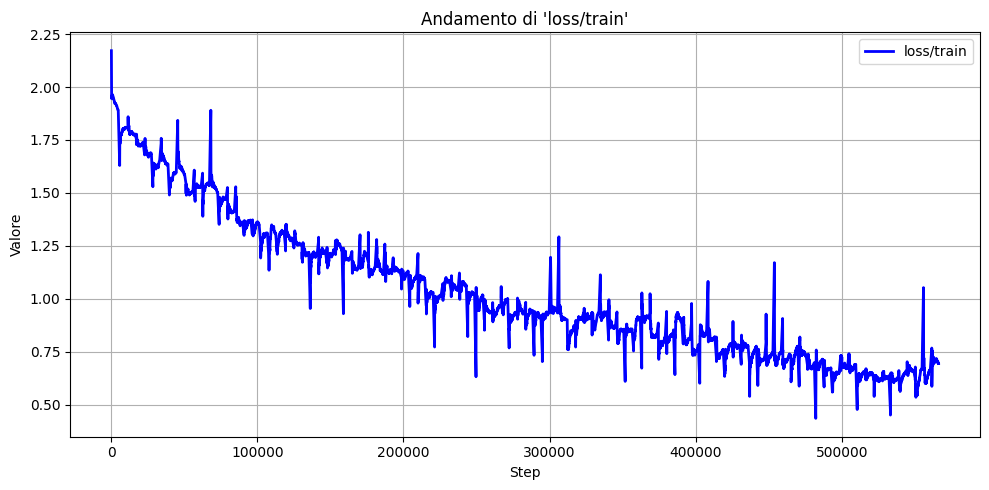

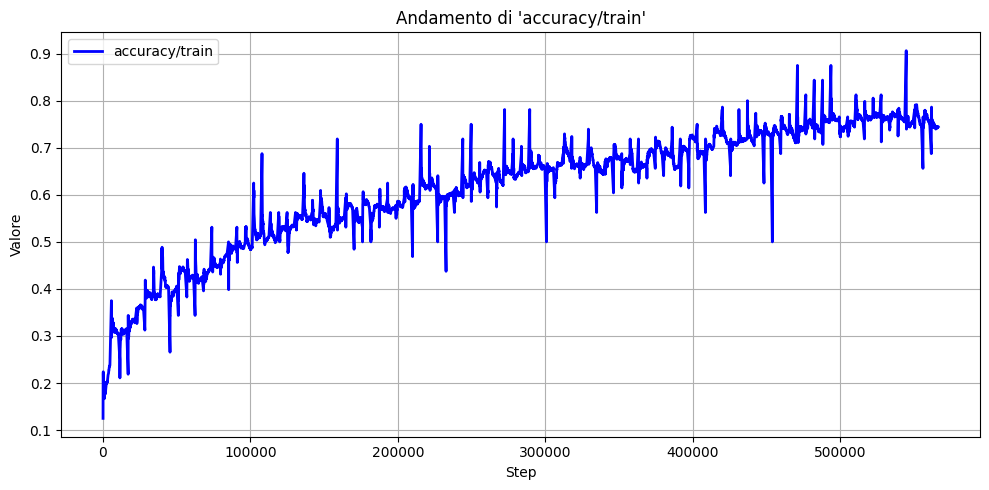

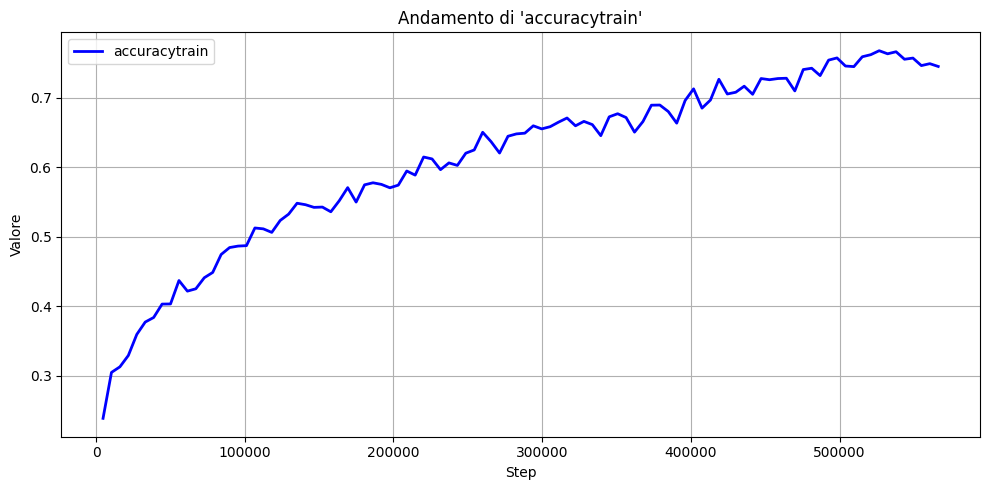

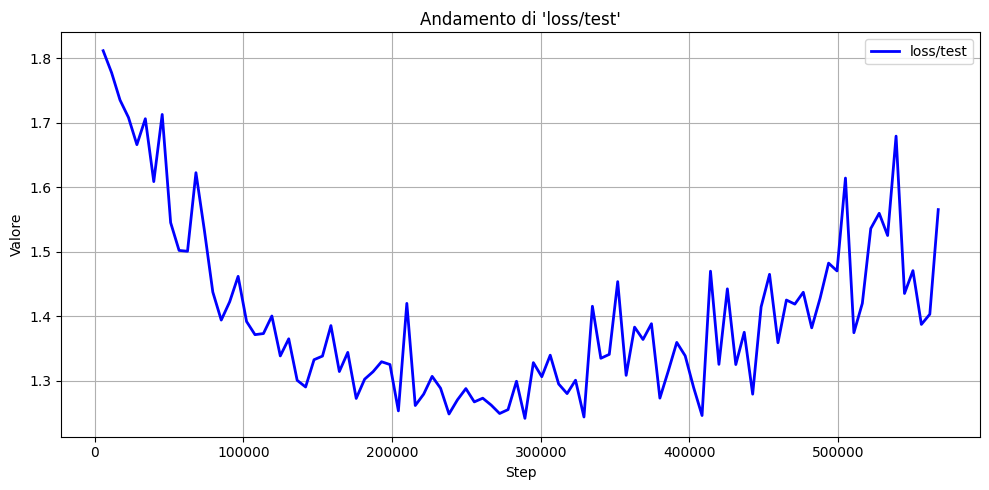

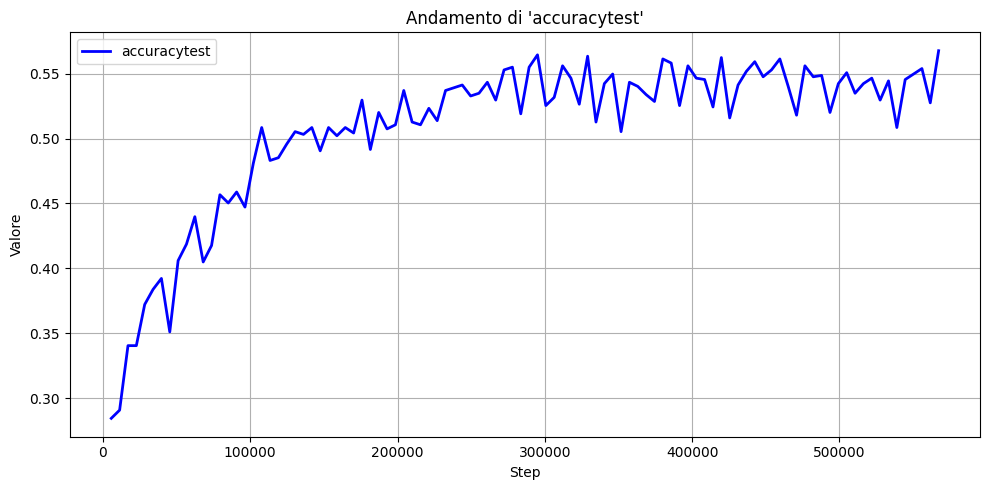

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

event_file = "logs/squeezenet_FER2013_finetuning/events.out.tfevents.1752913298.nokia4316.19680.0"

ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

for tag_to_plot in ea.Tags().get("scalars", []):

    if tag_to_plot not in ea.Tags()["scalars"]:
        print(f"Tag '{tag_to_plot}' non trovato. Disponibili: {ea.Tags()['scalars']}")
    else:
        events = ea.Scalars(tag_to_plot)
        steps = [e.step for e in events]
        values = [e.value for e in events]

        # === Plot ===
        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=tag_to_plot, color="blue", linewidth=2)
        plt.xlabel("Step")
        plt.ylabel("Valore")
        plt.title(f"Andamento di '{tag_to_plot}'")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [21]:
SqueezeNet_trained = squeezenet1_0(num_classes = 7)

SqueezeNet_trained.load_state_dict(torch.load("weights/squeezenet_FER2013_finetuning-100.pth"))
SqueezeNet_trained.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [22]:
SqueezeNet_trained_test, FER2013_labels_test = test_classifier(SqueezeNet_trained, FER2013_test_loader)
SqueezeNet_test_accuracy = accuracy_score(FER2013_labels_test, SqueezeNet_trained_test) * 100
print("Accuracy di Squeezenet su FER2013: %0.2f%%" % SqueezeNet_test_accuracy)

Accuracy di Squeezenet su FER2013: 69.67%


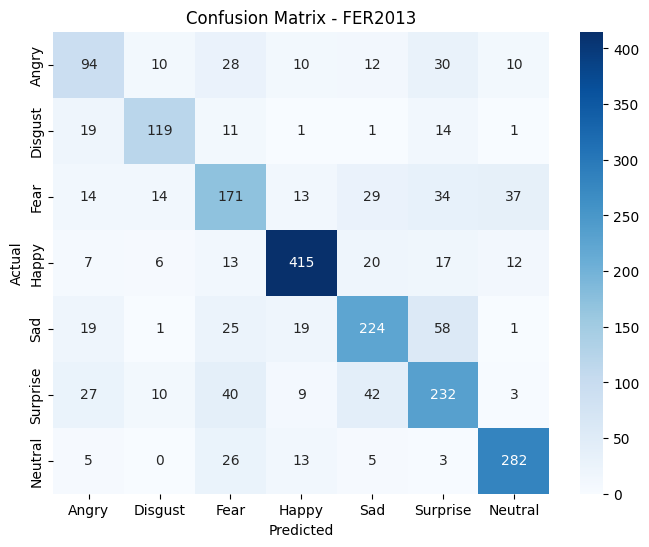

In [23]:
confusionMatrix(SqueezeNet_trained_test, FER2013_labels_test)

# Resnet

In [24]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
def get_resnet18_model(num_class = 7):
    model = resnet18(weights = ResNet18_Weights.DEFAULT)
    num_class = 7
    model.fc = nn.Linear(model.fc.in_features, num_class)
    return model

In [38]:
ResNet_trained = trainval_classifier(get_resnet18_model(), FER2013_train_loader,
                                        FER2013_valid_loader, exp_name='resnet_FER2013_finetuning',
                                        lr = 0.001, epochs = 100)

Epoch 1 of 100
3.85m
Epoch 2 of 100
3.45m
Epoch 3 of 100
3.48m
Epoch 4 of 100
3.37m
Epoch 5 of 100
3.35m
Epoch 6 of 100
3.35m
Epoch 7 of 100
3.60m
Epoch 8 of 100
3.95m
Epoch 9 of 100
3.43m
Epoch 10 of 100
3.40m
Epoch 11 of 100
3.34m
Epoch 12 of 100
3.38m
Epoch 13 of 100
3.35m
Epoch 14 of 100
3.33m
Epoch 15 of 100
3.37m
Epoch 16 of 100
3.90m
Epoch 17 of 100
3.46m
Epoch 18 of 100
3.43m
Epoch 19 of 100
3.42m
Epoch 20 of 100
3.46m
Epoch 21 of 100
3.40m
Epoch 22 of 100
3.64m
Epoch 23 of 100
3.40m
Epoch 24 of 100
3.59m
Epoch 25 of 100
3.43m
Epoch 26 of 100
3.44m
Epoch 27 of 100
3.87m
Epoch 28 of 100
3.45m
Epoch 29 of 100
3.40m
Epoch 30 of 100
3.34m
Epoch 31 of 100
3.33m
Epoch 32 of 100
3.59m
Epoch 33 of 100
3.69m
Epoch 34 of 100
3.43m
Epoch 35 of 100
3.39m
Epoch 36 of 100
3.35m
Epoch 37 of 100
3.86m
Epoch 38 of 100
4.17m
Epoch 39 of 100
3.44m
Epoch 40 of 100
3.57m
Epoch 41 of 100
3.64m
Epoch 42 of 100
3.39m
Epoch 43 of 100
3.95m
Epoch 44 of 100
3.76m
Epoch 45 of 100
3.42m
Epoch 46 of 100
3.3

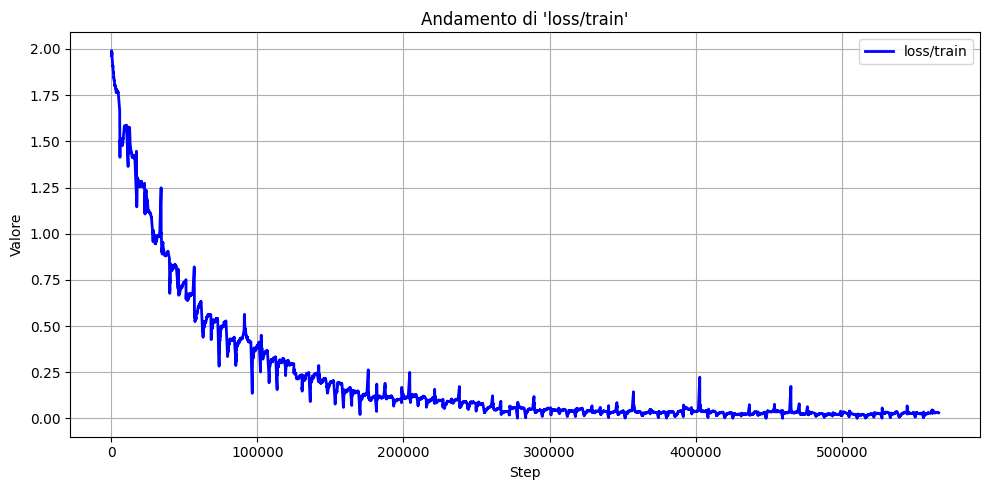

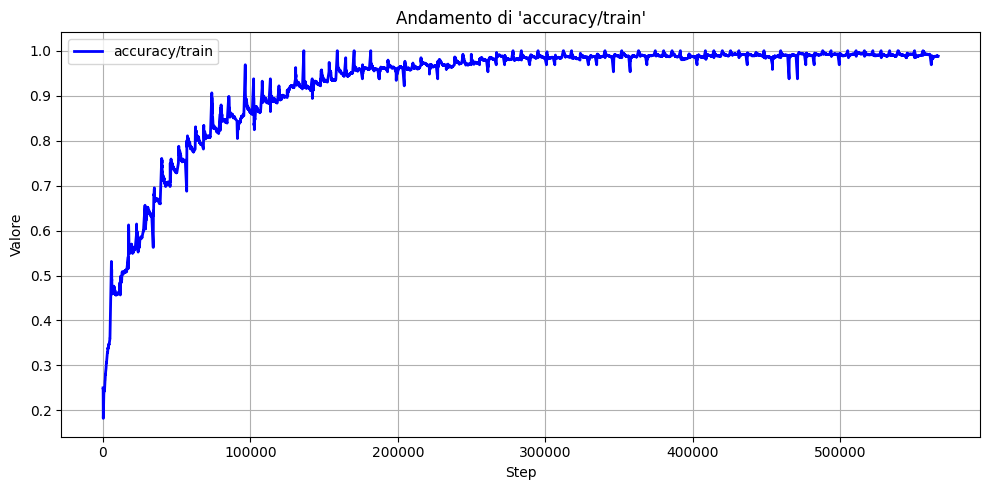

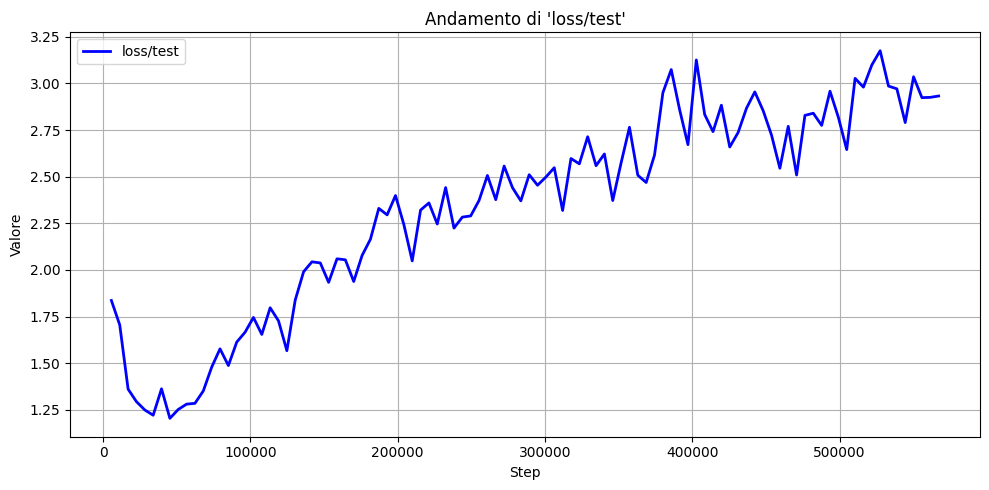

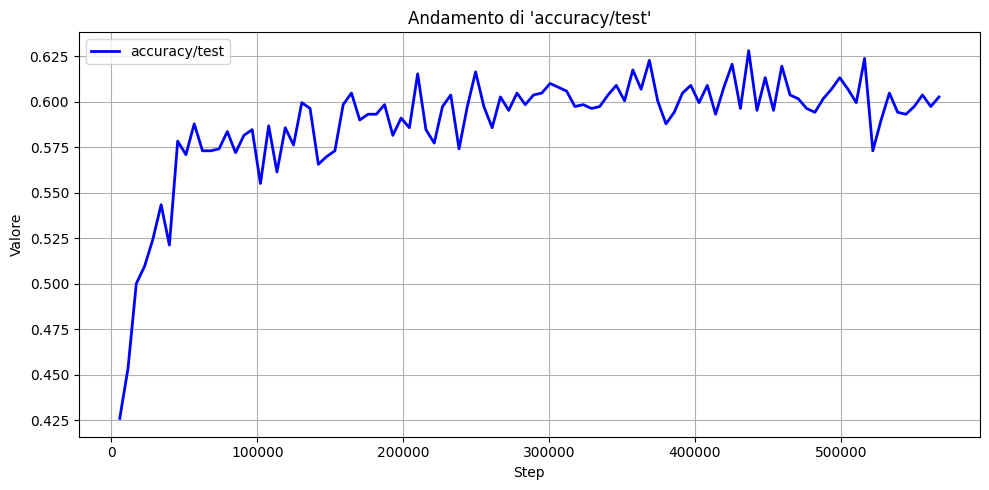

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

event_file = "logs/resnet_FER2013_finetuning/events.out.tfevents.1753021209.nokia4316.19680.1"

ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

for tag_to_plot in ea.Tags().get("scalars", []):

    if tag_to_plot not in ea.Tags()["scalars"]:
        print(f"Tag '{tag_to_plot}' non trovato. Disponibili: {ea.Tags()['scalars']}")
    else:
        events = ea.Scalars(tag_to_plot)
        steps = [e.step for e in events]
        values = [e.value for e in events]

        # === Plot ===
        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=tag_to_plot, color="blue", linewidth=2)
        plt.xlabel("Step")
        plt.ylabel("Valore")
        plt.title(f"Andamento di '{tag_to_plot}'")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [25]:
ResNet_trained = resnet18(num_classes = 7)

ResNet_trained.load_state_dict(torch.load("weights/resnet_FER2013_finetuning-100.pth"))
ResNet_trained.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
ResNet_trained_test, FER2013_labels_test = test_classifier(ResNet_trained, FER2013_test_loader)
resnet_accuracy_test = accuracy_score(FER2013_labels_test, ResNet_trained_test) * 100
print("Accuracy di ResNet su FER2013: %0.2f%%" % resnet_accuracy_test)

Accuracy di ResNet su FER2013: 84.18%


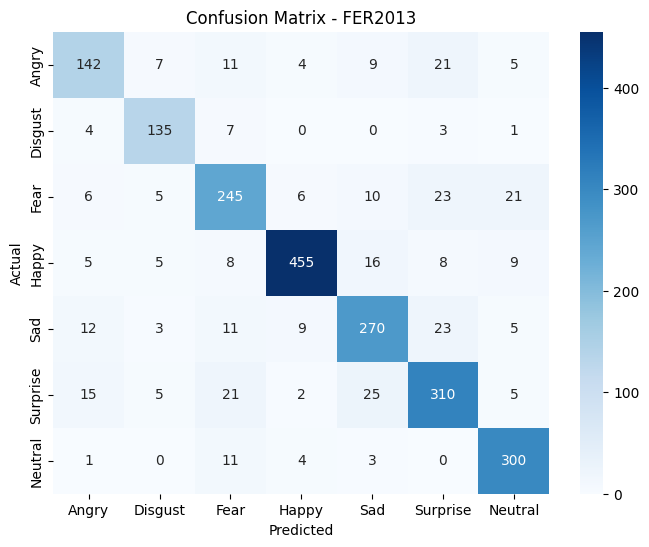

In [27]:
confusionMatrix(ResNet_trained_test, FER2013_labels_test)

# Confronto dei risultati
Per concludere facciamo il paragone dei risultati ottenuti sui tre modelli:

In [32]:
import os
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

LOG_DIR = "logs"

experiments = [
    ("efficientnet_FER2013_finetuning", EfficientNet_trained),
    ("squeezenet_FER2013_finetuning", SqueezeNet_trained),
    ("resnet_FER2013_finetuning", ResNet_trained)
]

def extract_final_metrics(log_dir, experiment):
    path = os.path.join(log_dir, experiment)
    if not os.path.isdir(path):
        print(f"[!] Directory non trovata: {path}")
        return None, None

    ea = event_accumulator.EventAccumulator(path)
    try:
        ea.Reload()
    except Exception as e:
        print(f"[!] Errore nel leggere i log di {experiment}: {e}")
        return None, None

    def get_last_scalar(tag):
        if tag in ea.Tags()['scalars']:
            events = ea.Scalars(tag)
            if events:
                return events[-1].value
        return None
    final_acc = get_last_scalar('accuracy/val')
    final_loss = get_last_scalar('loss/val')
    return final_acc, final_loss

# Stampa i risultati in tabella
print(f"{'Modello':<35} | {'Accuracy/val':<15} | {'Loss/train':<15} | {'accuracy/test':<15} | {'Recall':<15} | {'Precision':<15} | {'F1 score':<15}")
print("-" * 136)


for name, model in experiments:
    
    preds, labels = test_classifier(model, FER2013_test_loader)
    
    acc_test = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average = 'macro')
    precision = precision_score(labels, preds, average = 'macro')
    recall = recall_score(labels, preds, average = 'macro')
    
    acc, loss = extract_final_metrics(LOG_DIR, name)
    acc_str = f"{acc:.4f}" if acc is not None else "N/A"
    loss_str = f"{loss:.4f}" if loss is not None else "N/A"

    print(f"{name:<35} | {acc_str:<15} | {loss_str:<15} | {acc_test:<15.4f} | {recall:<15.4} | {precision:<15.4} | {f1:<15.4}")

Modello                             | Accuracy/val    | Loss/train      | accuracy/test   | Recall          | Precision       | F1 score       
----------------------------------------------------------------------------------------------------------------------------------------
efficientnet_FER2013_finetuning     | 0.5877          | 2.6193          | 0.8504          | 0.8418          | 0.8416          | 0.8413         
squeezenet_FER2013_finetuning       | 0.5835          | 1.3484          | 0.7004          | 0.6893          | 0.6839          | 0.6858         
resnet_FER2013_finetuning           | 0.6015          | 2.8361          | 0.8391          | 0.8275          | 0.8352          | 0.8308         
